# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст. 
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

class Head(nn.Module):
    def __init__(self, head_size, n_embed, block_size):
        super().__init__()
        self.key   = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)                            
        q = self.query(x)                         
        wei = q @ k.transpose(-2, -1) / (C**0.5)  
        wei = wei.masked_fill(self.tril[:T, :T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)            
        wei = self.dropout(wei)
        v = self.value(x)                        
        out = wei @ v                       
        return out, wei    

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embed, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embed, block_size)
                                    for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        head_outs    = []
        all_attents  = []
        for head in self.heads:
            out, attn = head(x)
            head_outs.append(out)
            all_attents.append(attn)
        out = torch.cat(head_outs, dim=-1)     
        out = self.dropout(self.proj(out))   
        return out, all_attents  

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(0.1),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head, block_size):
        super().__init__()
        head_size = n_embed // n_head
        self.sa    = MultiHeadAttention(n_head, head_size, n_embed, block_size)
        self.ffwd  = FeedForward(n_embed)
        self.ln1   = nn.LayerNorm(n_embed)
        self.ln2   = nn.LayerNorm(n_embed)

    def forward(self, x):
        attn_out, attn_weights = self.sa(self.ln1(x))
        x = x + attn_out
        x = x + self.ffwd(self.ln2(x))
        return x, attn_weights

In [2]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, n_embed, block_size, n_layer, n_head):
        super().__init__()
        self.token_embedding_table    = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.ModuleList([
            Block(n_embed, n_head, block_size) for _ in range(n_layer)
        ])
        self.ln_f   = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.block_size = block_size

        self.last_attentions = None

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)          
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=idx.device)
        )[None, :, :]                                   
        x = tok_emb + pos_emb                              

        attentions_all = []
        for block in self.blocks:
            x, attn = block(x)
            attentions_all.append(attn)                 

        x = self.ln_f(x)                                
        logits = self.lm_head(x)                          

        self.last_attentions = attentions_all

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

In [3]:
def plot_attention(attn_layers, epoch, tokens):
    n_layers = len(attn_layers)
    n_heads  = len(attn_layers[0])
    for layer in range(n_layers):
        for head in range(n_heads):
            plt.figure(figsize=(5, 4))
            sns.heatmap(attn_layers[layer][head],
                        xticklabels=tokens,
                        yticklabels=tokens,
                        cmap="viridis")
            plt.title(f"Epoch {epoch+1} — Layer {layer} — Head {head}")
            plt.xlabel("Key pos")
            plt.ylabel("Query pos")
            plt.tight_layout()
            plt.show()


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [9]:
import pandas as pd
import torch

df = pd.read_csv(
    'https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip',
    compression='zip'
)

texts = df['text'].astype(str).tolist()

full_text = " ".join(texts)
words = full_text.strip().split()

vocab = sorted(set(words))
stoi = {w: i for i, w in enumerate(vocab)}
itos = {i: w for w, i in enumerate(vocab)}
vocab_size = len(vocab)

data = torch.tensor([stoi[word] for word in words], dtype=torch.long)

n = int(0.9 * len(data))
train_data = data[:n]
val_data   = data[n:]

block_size = 8
batch_size = 32

def get_batch(split):
    split_data = train_data if split == 'train' else val_data
    ix = torch.randint(len(split_data) - block_size, (batch_size,))
    x = torch.stack([split_data[i:i+block_size]     for i in ix])
    y = torch.stack([split_data[i+1:i+block_size+1] for i in ix])
    return x, y

In [10]:
model = BigramLanguageModel(
    vocab_size=vocab_size,
    n_embed=64,     
    block_size=block_size,
    n_layer=2,     
    n_head=4
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [11]:
attentions_by_epoch = []

num_epochs = 5
iterations_per_epoch = 500 # ооочень большие эпохи 

for epoch in range(num_epochs):
    model.train()
    for _ in tqdm(range(iterations_per_epoch)):
        xb, yb = get_batch('train')   
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        xb, _ = get_batch('val')
        xb = xb.to(device)
        _ = model(xb)     
        raw_attns = model.last_attentions
        epoch_attns = [
            [ head_attn[0].cpu().numpy() for head_attn in layer_attn ]
            for layer_attn in raw_attns
        ]
        attentions_by_epoch.append(epoch_attns)

example_ids = xb[0].cpu().tolist()
tokens = [vocab[token_id] for token_id in example_ids]

100%|█████████████████████████████████████████| 500/500 [00:32<00:00, 15.37it/s]


In [12]:
import math
def plot_attention(attn_layers, epoch, tokens, n_cols=4):
    for layer_idx, heads in enumerate(attn_layers):
        n_heads = len(heads)
        n_rows  = math.ceil(n_heads / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols,
                                 figsize=(n_cols*4, n_rows*4),
                                 squeeze=False) 

        for h, attn in enumerate(heads):
            r, c = divmod(h, n_cols)
            ax   = axes[r][c]
            sns.heatmap(attn,
                        ax=ax,
                        cmap="viridis",
                        xticklabels=tokens,
                        yticklabels=tokens,
                        cbar=True)
            ax.set_title(f"Head {h+1}", fontsize=10)
            ax.tick_params(axis='both', labelsize=7, labelrotation=0)
            ax.set_xlabel("")
            ax.set_ylabel("")

        for h in range(n_heads, n_rows*n_cols):
            r, c = divmod(h, n_cols)
            axes[r][c].axis("off")

        fig.suptitle(f"Epoch {epoch+1} — Layer {layer_idx}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

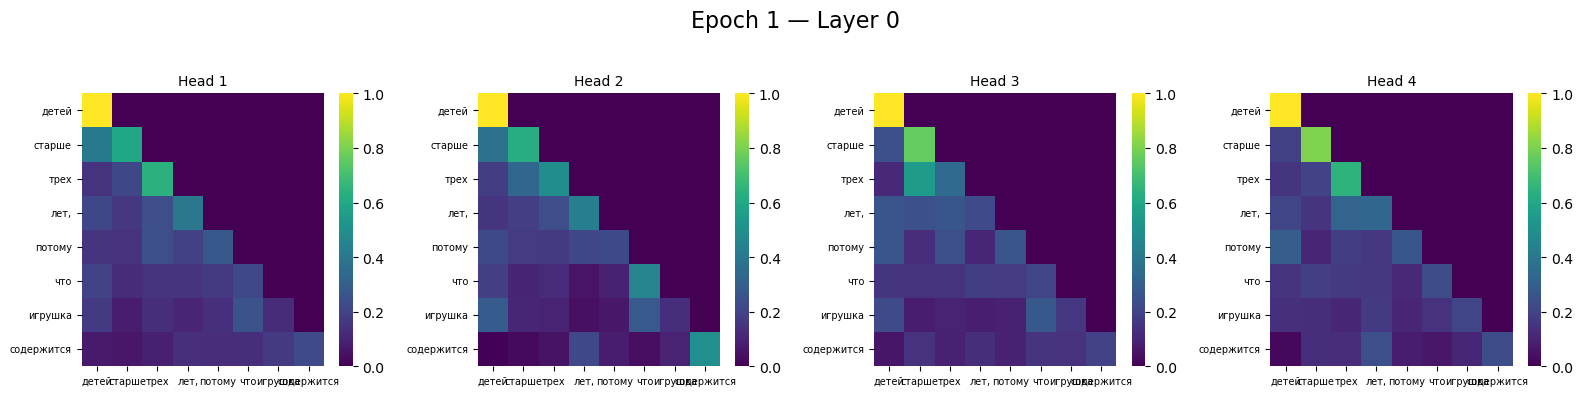

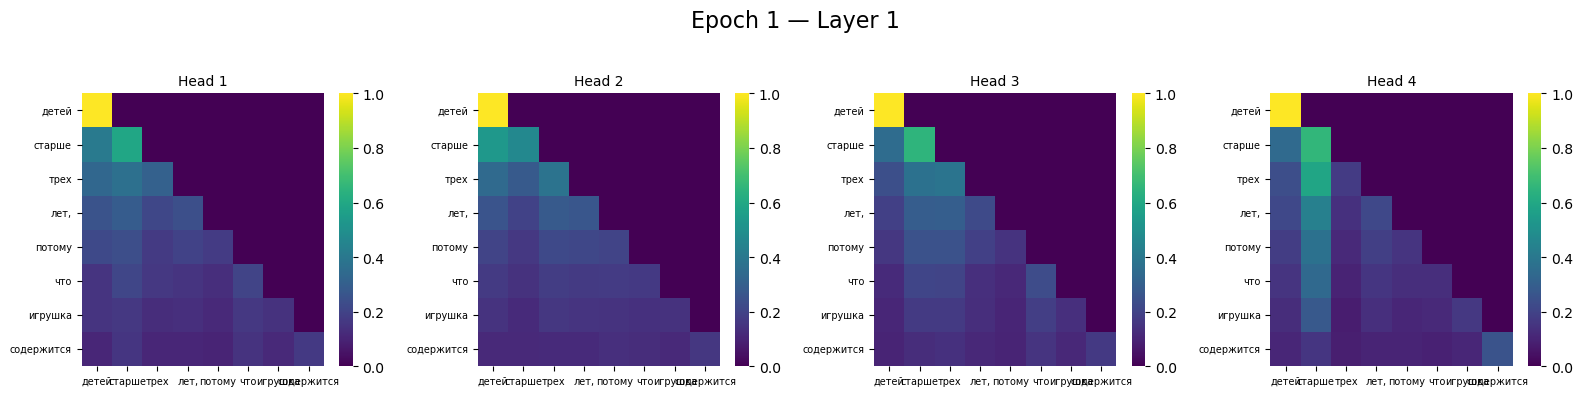

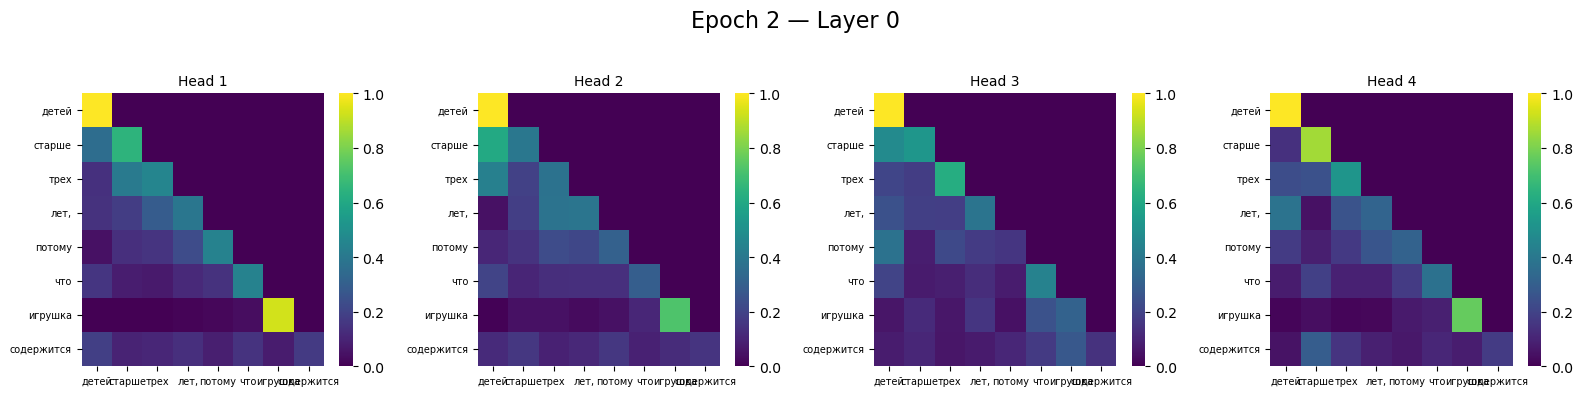

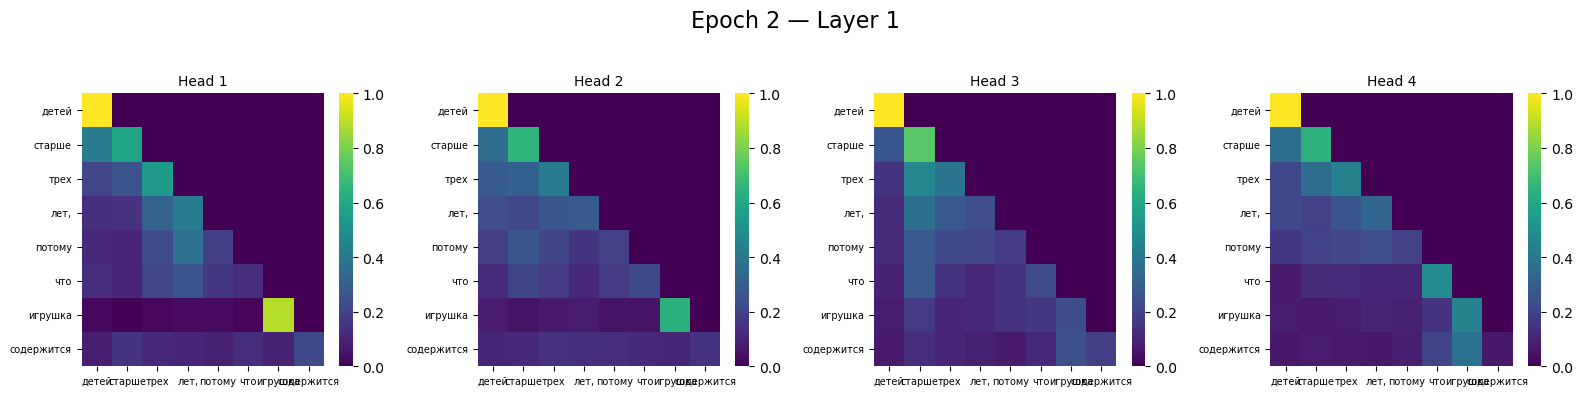

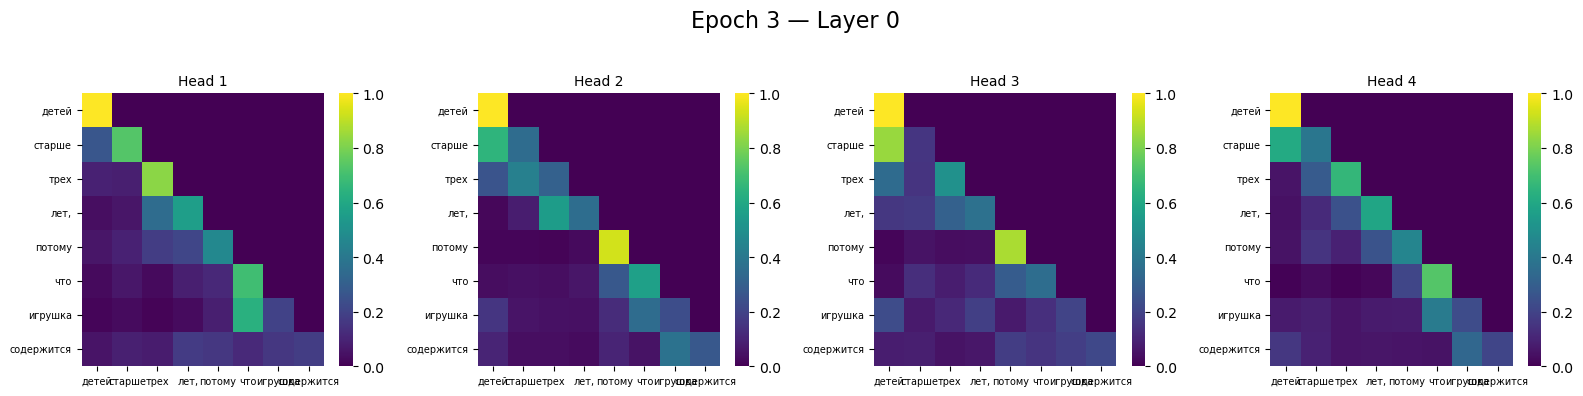

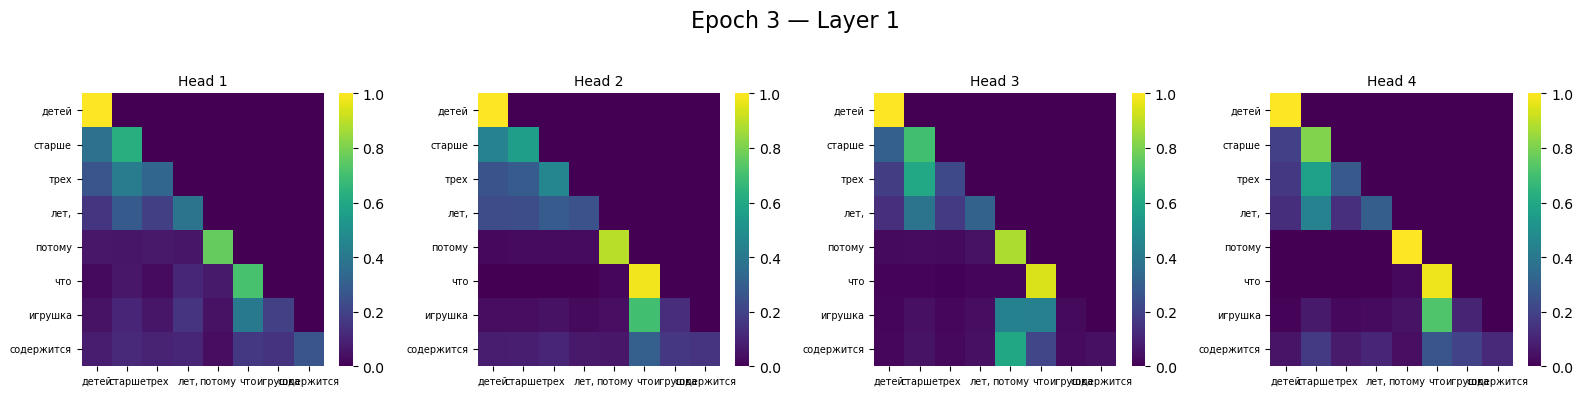

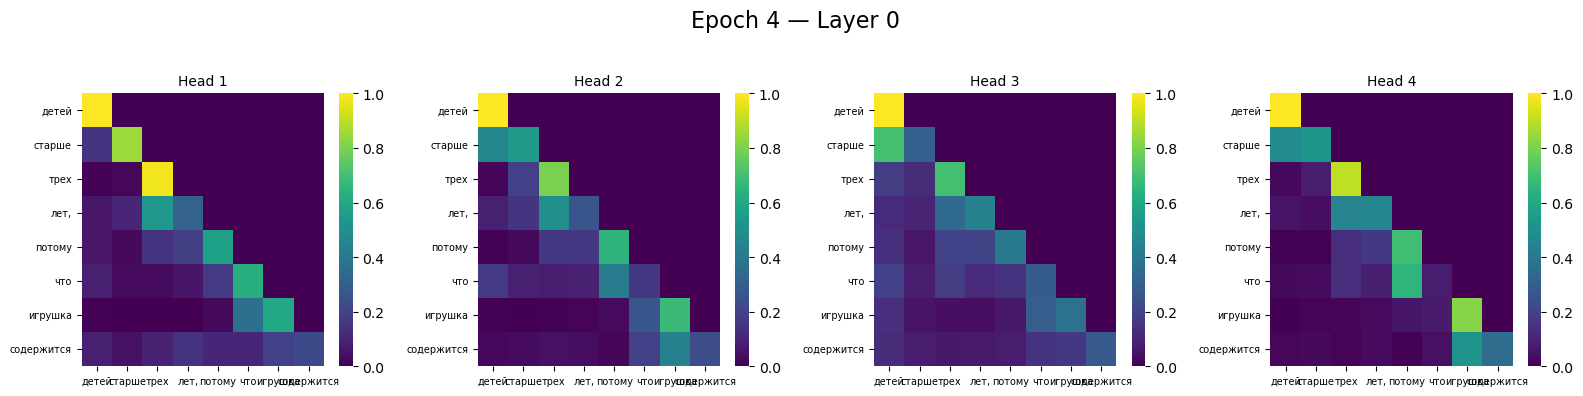

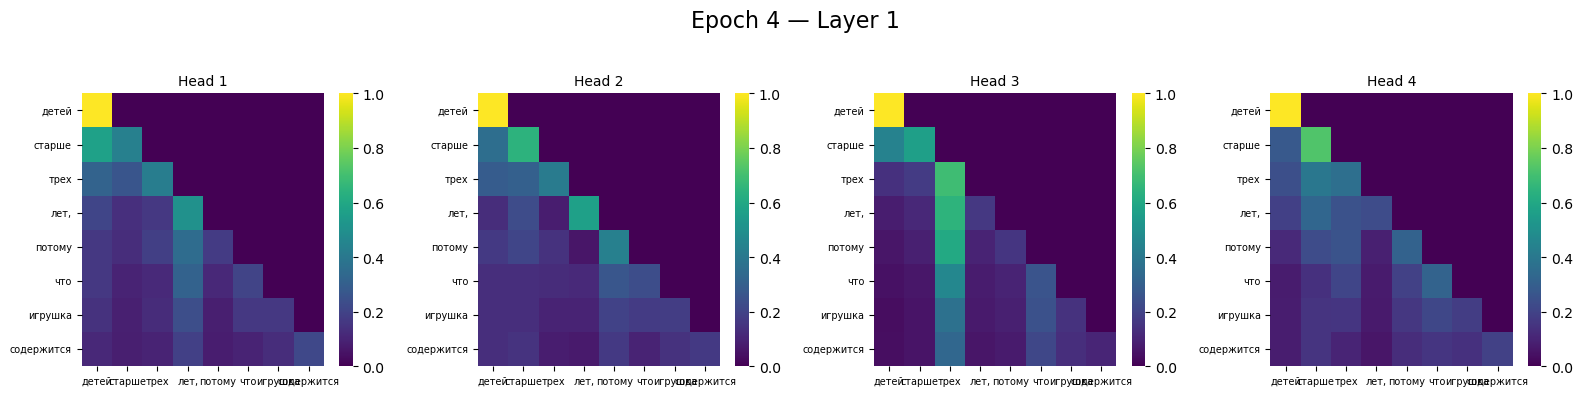

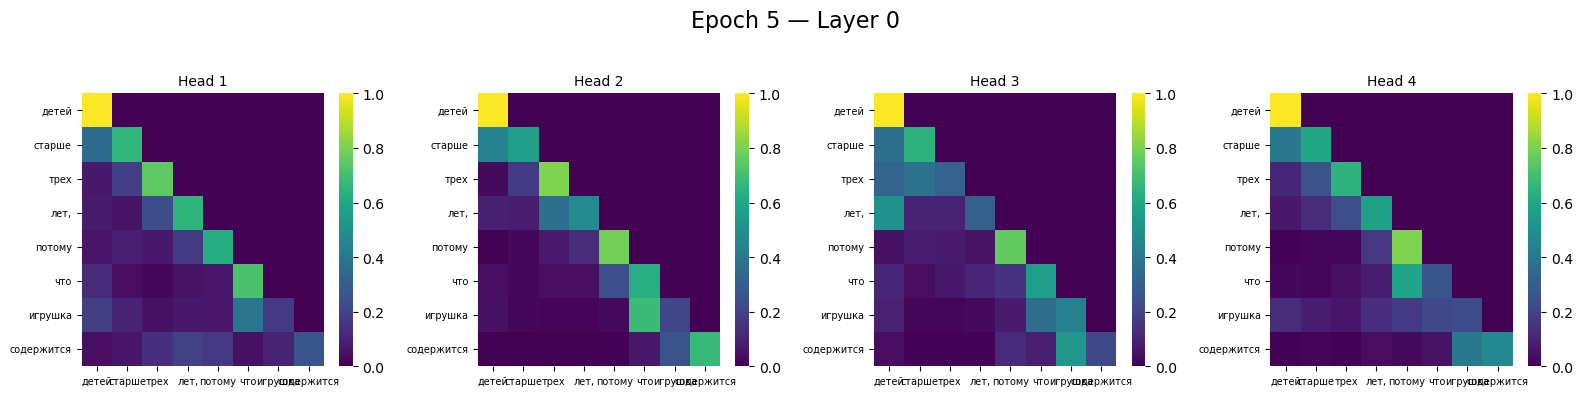

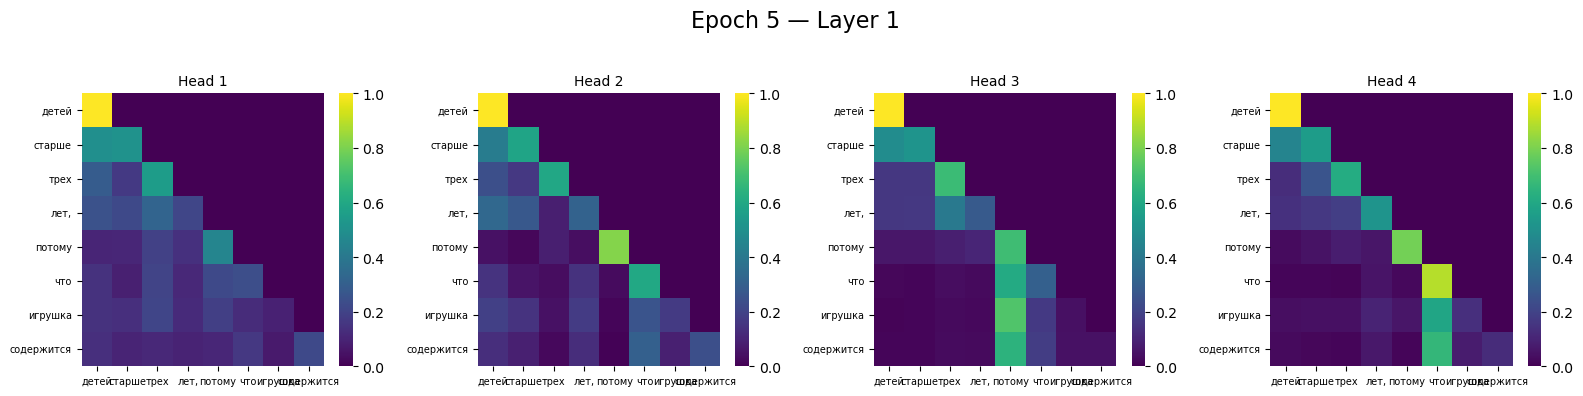

In [13]:
for e, attn in enumerate(attentions_by_epoch):
    plot_attention(attn, e, tokens)